# **Imports**

## **Base Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import copy
import torch
import random
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from tqdm.notebook import tqdm
from torchvision.transforms import v2
from torch.utils.data import random_split
from torch.utils.data import TensorDataset, DataLoader

import gc
import time
import optuna
import torchinfo

import nndl.utils as utils
import nndl.models.cnn as cnn
import nndl.models.cgru as cgru
import nndl.models.clstm as clstm
import nndl.models.ctransformer as ctransformer
import nndl.models.gru as gru
import nndl.models.llstm as llstm

## **GPU**

In [2]:
if torch.cuda.is_available():
  device = torch.device('cuda')
elif torch.backends.mps.is_available():
  device = torch.device('mps')
else:
  device = torch.device('cpu')

print("Using", device)

Using cuda


## **Seeds**

In [3]:
random.seed(1337)
np.random.seed(1337)
torch.manual_seed(1337)

# **Data Preparation**

## **Load Data**

In [4]:
X_test = np.load("./project_data/X_test.npy")
y_test = np.load("./project_data/y_test.npy") - 769
person_train_valid = np.load("./project_data/person_train_valid.npy")
X_train_valid = np.load("./project_data/X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("./project_data/y_train_valid.npy") - 769
person_test = np.load("./project_data/person_test.npy")

print(X_train_valid.shape)
print(X_test.shape)

print(y_train_valid)

(2115, 22, 1000)
(2115, 22, 1000)
(443, 22, 1000)
[2 3 0 ... 3 3 2]


In [5]:
batch_size = 64

folds = 10
split_seed = 1

subsample = 2
average = 2
noise = True
p_channel_dropout = 0
smooth_time_mask = False
mask_size = 0
time_shift = 0
clipping_max = 800
noise_stdev = 0.5

In [6]:
X_train_valid = torch.Tensor(X_train_valid)
y_train_valid = torch.Tensor(y_train_valid)

print(f'SOME {X_train_valid.shape}')
indices = torch.randperm(X_train_valid.shape[0])

split_idx = int(X_train_valid.shape[0] * ((folds-1)/folds))

X_train, X_valid = X_train_valid[indices[:split_idx]], X_train_valid[indices[split_idx:]]
y_train, y_valid = y_train_valid[indices[:split_idx]], y_train_valid[indices[split_idx:]]
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

person_train_valid, person_test = torch.Tensor(person_train_valid), torch.Tensor(person_test)
person_train, person_valid = person_train_valid[indices[:split_idx]], person_train_valid[indices[split_idx:]]

SOME torch.Size([2115, 22, 1000])


## **Separate X_train by subject using person_train**

In [7]:
s_train = [[], [], [], [], [], [], [], [], []]
s_y_train = [[], [], [], [], [], [], [], [], []]
count_train = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for (i, j) in zip(person_train, range(len(person_train))):
    #i is a np.darray from subject_train, i[0] gives us the subject
    #j is the index of i in subject_train that corresponds to the index in subject_train
    s_train[int(i[0])].append(X_train[j])
    s_y_train[int(i[0])].append(y_train[j])
    
    #for length check
    count_train[int(i[0])]+=1

print('subject counts: ', count_train)
print('subject count sum: ', sum(count_train))

#lebron
for (i, j, k) in zip(count_train, s_train, s_y_train):
    if i != len(j) or i != len(k):
        print("length issue")


print('\nsubject 0')
s0_train, s0_y_train = utils.data_prep(torch.Tensor(np.asarray(s_train[0])),
                                       torch.Tensor(np.asarray(s_y_train[0])),
                                       subsample,
                                       average,
                                       noise,
                                       p_channel_dropout,
                                       smooth_time_mask,
                                       mask_size)
print('\nsubject 1')
s1_train, s1_y_train = utils.data_prep(torch.Tensor(np.asarray(s_train[1])),
                                       torch.Tensor(np.asarray(s_y_train[1])),
                                       subsample,
                                       average,
                                       noise,
                                       p_channel_dropout,
                                       smooth_time_mask,
                                       mask_size)
print('\nsubject 2')
s2_train, s2_y_train = utils.data_prep(torch.Tensor(np.asarray(s_train[2])),
                                       torch.Tensor(np.asarray(s_y_train[2])),
                                       subsample,
                                       average,
                                       noise,
                                       p_channel_dropout,
                                       smooth_time_mask,
                                       mask_size)
print('\nsubject 3')
s3_train, s3_y_train = utils.data_prep(torch.Tensor(np.asarray(s_train[3])),
                                       torch.Tensor(np.asarray(s_y_train[3])),
                                       subsample,
                                       average,
                                       noise,
                                       p_channel_dropout,
                                       smooth_time_mask,
                                       mask_size)
print('\nsubject 4')
s4_train, s4_y_train = utils.data_prep(torch.Tensor(np.asarray(s_train[4])),
                                       torch.Tensor(np.asarray(s_y_train[4])),
                                       subsample,
                                       average,
                                       noise,
                                       p_channel_dropout,
                                       smooth_time_mask,
                                       mask_size)
print('\nsubject 5')
s5_train, s5_y_train = utils.data_prep(torch.Tensor(np.asarray(s_train[5])),
                                       torch.Tensor(np.asarray(s_y_train[5])),
                                       subsample,
                                       average,
                                       noise,
                                       p_channel_dropout,
                                       smooth_time_mask,
                                       mask_size)
print('\nsubject 6')
s6_train, s6_y_train = utils.data_prep(torch.Tensor(np.asarray(s_train[6])),
                                       torch.Tensor(np.asarray(s_y_train[6])),
                                       subsample,
                                       average,
                                       noise,
                                       p_channel_dropout,
                                       smooth_time_mask,
                                       mask_size)
print('\nsubject 7')
s7_train, s7_y_train = utils.data_prep(torch.Tensor(np.asarray(s_train[7])),
                                       torch.Tensor(np.asarray(s_y_train[7])),
                                       subsample,
                                       average,
                                       noise,
                                       p_channel_dropout,
                                       smooth_time_mask,
                                       mask_size)
print('\nsubject 8')
s8_train, s8_y_train = utils.data_prep(torch.Tensor(np.asarray(s_train[8])),
                                       torch.Tensor(np.asarray(s_y_train[8])),
                                       subsample,
                                       average,
                                       noise,
                                       p_channel_dropout,
                                       smooth_time_mask,
                                       mask_size)

subject counts:  [221, 212, 213, 208, 207, 203, 214, 216, 209]
subject count sum:  1903

subject 0
Shape of X after trimming: {X.shape}
Shape of X after maxpooling: torch.Size([221, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([442, 22, 400])
torch.Size([442, 1])
torch.Size([221, 1])
torch.Size([663, 1])
torch.Size([221, 1])
Shape of X after subsampling and concatenating: torch.Size([884, 22, 400])
Shape of Y: torch.Size([884])

subject 1
Shape of X after trimming: {X.shape}
Shape of X after maxpooling: torch.Size([212, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([424, 22, 400])
torch.Size([424, 1])
torch.Size([212, 1])
torch.Size([636, 1])
torch.Size([212, 1])
Shape of X after subsampling and concatenating: torch.Size([848, 22, 400])
Shape of Y: torch.Size([848])

subject 2
Shape of X after trimming: {X.shape}
Shape of X after maxpooling: torch.Size([213, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([

## **Separate X_val by subject using person_valid**

In [8]:
print(X_valid.shape)

s_valid = [[], [], [], [], [], [], [], [], []]
s_y_valid = [[], [], [], [], [], [], [], [], []]
count_val = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for (i, j) in zip(person_valid, range(len(person_valid))):
    #i is a np.darray from subject_train, i[0] gives us the subject
    #j is the index of i in subject_train that corresponds to the index in subject_train
    s_valid[int(i[0])].append(X_valid[j])
    s_y_valid[int(i[0])].append(y_valid[j])

    #for length check
    count_val[int(i[0])]+=1

print('val counts: ', count_val)
print('val count sum: ', sum(count_val))

#lebron
for (i, j, k) in zip(count_val, s_valid, s_y_valid):
    if i != len(j) or i != len(k):
        print("length issue")

print('\nsubject 0')
s0_valid, s0_y_valid = utils.data_prep(torch.Tensor(np.asarray(s_valid[0])),
                                       torch.Tensor(np.asarray(s_y_valid[0])),
                                       subsample,
                                       average,
                                       noise,
                                       p_channel_dropout,
                                       smooth_time_mask,
                                       mask_size)
print('\nsubject 1')
s1_valid, s1_y_valid = utils.data_prep(torch.Tensor(np.asarray(s_valid[1])),
                                       torch.Tensor(np.asarray(s_y_valid[1])),
                                       subsample,
                                       average,
                                       noise,
                                       p_channel_dropout,
                                       smooth_time_mask,
                                       mask_size)
print('\nsubject 2')
s2_valid, s2_y_valid = utils.data_prep(torch.Tensor(np.asarray(s_valid[2])),
                                       torch.Tensor(np.asarray(s_y_valid[2])),
                                       subsample,
                                       average,
                                       noise,
                                       p_channel_dropout,
                                       smooth_time_mask,
                                       mask_size)
print('\nsubject 3')
s3_valid, s3_y_valid = utils.data_prep(torch.Tensor(np.asarray(s_valid[3])),
                                       torch.Tensor(np.asarray(s_y_valid[3])),
                                       subsample,
                                       average,
                                       noise,
                                       p_channel_dropout,
                                       smooth_time_mask,
                                       mask_size)
print('\nsubject 4')
s4_valid, s4_y_valid = utils.data_prep(torch.Tensor(np.asarray(s_valid[4])),
                                       torch.Tensor(np.asarray(s_y_valid[4])),
                                       subsample,
                                       average,
                                       noise,
                                       p_channel_dropout,
                                       smooth_time_mask,
                                       mask_size)
print('\nsubject 5')
s5_valid, s5_y_valid = utils.data_prep(torch.Tensor(np.asarray(s_valid[5])),
                                       torch.Tensor(np.asarray(s_y_valid[5])),
                                       subsample,
                                       average,
                                       noise,
                                       p_channel_dropout,
                                       smooth_time_mask,
                                       mask_size)
print('\nsubject 6')
s6_valid, s6_y_valid = utils.data_prep(torch.Tensor(np.asarray(s_valid[6])),
                                       torch.Tensor(np.asarray(s_y_valid[6])),
                                       subsample,
                                       average,
                                       noise,
                                       p_channel_dropout,
                                       smooth_time_mask,
                                       mask_size)
print('\nsubject 7')
s7_valid, s7_y_valid = utils.data_prep(torch.Tensor(np.asarray(s_valid[7])),
                                       torch.Tensor(np.asarray(s_y_valid[7])),
                                       subsample,
                                       average,
                                       noise,
                                       p_channel_dropout,
                                       smooth_time_mask,
                                       mask_size)
print('\nsubject 8')
s8_valid, s8_y_valid = utils.data_prep(torch.Tensor(np.asarray(s_valid[8])),
                                       torch.Tensor(np.asarray(s_y_valid[8])),
                                       subsample,
                                       average,
                                       noise,
                                       p_channel_dropout,
                                       smooth_time_mask,
                                       mask_size)

torch.Size([212, 22, 1000])
val counts:  [16, 24, 23, 26, 28, 33, 24, 16, 22]
val count sum:  212

subject 0
Shape of X after trimming: {X.shape}
Shape of X after maxpooling: torch.Size([16, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([32, 22, 400])
torch.Size([32, 1])
torch.Size([16, 1])
torch.Size([48, 1])
torch.Size([16, 1])
Shape of X after subsampling and concatenating: torch.Size([64, 22, 400])
Shape of Y: torch.Size([64])

subject 1
Shape of X after trimming: {X.shape}
Shape of X after maxpooling: torch.Size([24, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([48, 22, 400])
torch.Size([48, 1])
torch.Size([24, 1])
torch.Size([72, 1])
torch.Size([24, 1])
Shape of X after subsampling and concatenating: torch.Size([96, 22, 400])
Shape of Y: torch.Size([96])

subject 2
Shape of X after trimming: {X.shape}
Shape of X after maxpooling: torch.Size([23, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([46, 22,

## **Separate X_test by subject using person_test**

In [9]:
print(X_test.shape)

s_test = [[], [], [], [], [], [], [], [], []]
s_y_test = [[], [], [], [], [], [], [], [], []]
count_test = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for (i, j) in zip(person_test, range(len(person_test))):
    #i is a np.darray from person_test, i[0] gives us the subject
    #j is the index of i in person_test that corresponds to the index in X_test
    s_test[int(i[0])].append(X_test[j])
    s_y_test[int(i[0])].append(y_test[j])

    #for length check
    count_test[int(i[0])]+=1

print('test counts: ', count_test)
print('test count sum: ', sum(count_test))

#lebron length check
for (i, j, k) in zip(count_test, s_test, s_y_test):
    if i != len(j) or i != len(k):
        print("length issue")

#Look in my eyes, tell me your tale Do you see the road, the map to my soul? Look, tell me the signs whenever the smoke clear out of my face Am I picture-perfect or do I look fried?
print('\nsubject 0')
s0_test, s0_y_test = utils.test_data_prep(torch.Tensor(np.asarray(s_test[0]))), torch.Tensor(np.asarray(s_y_test[0]))
print('\nsubject 1')
s1_test, s1_y_test = utils.test_data_prep(torch.Tensor(np.asarray(s_test[1]))), torch.Tensor(np.asarray(s_y_test[1]))
print('\nsubject 2')
s2_test, s2_y_test = utils.test_data_prep(torch.Tensor(np.asarray(s_test[2]))), torch.Tensor(np.asarray(s_y_test[2]))
print('\nsubject 3')
s3_test, s3_y_test = utils.test_data_prep(torch.Tensor(np.asarray(s_test[3]))), torch.Tensor(np.asarray(s_y_test[3]))
print('\nsubject 4')
s4_test, s4_y_test = utils.test_data_prep(torch.Tensor(np.asarray(s_test[4]))), torch.Tensor(np.asarray(s_y_test[4]))
print('\nsubject 5')
s5_test, s5_y_test = utils.test_data_prep(torch.Tensor(np.asarray(s_test[5]))), torch.Tensor(np.asarray(s_y_test[5]))
print('\nsubject 6')
s6_test, s6_y_test = utils.test_data_prep(torch.Tensor(np.asarray(s_test[6]))), torch.Tensor(np.asarray(s_y_test[6]))
print('\nsubject 7')
s7_test, s7_y_test = utils.test_data_prep(torch.Tensor(np.asarray(s_test[7]))), torch.Tensor(np.asarray(s_y_test[7]))
print('\nsubject 8')
s8_test, s8_y_test = utils.test_data_prep(torch.Tensor(np.asarray(s_test[8]))), torch.Tensor(np.asarray(s_y_test[8]))

torch.Size([443, 22, 1000])
test counts:  [50, 50, 50, 50, 47, 49, 50, 50, 47]
test count sum:  443

subject 0
Shape of X after trimming: torch.Size([50, 22, 800])
Shape of X after maxpooling: torch.Size([50, 22, 400])

subject 1
Shape of X after trimming: torch.Size([50, 22, 800])
Shape of X after maxpooling: torch.Size([50, 22, 400])

subject 2
Shape of X after trimming: torch.Size([50, 22, 800])
Shape of X after maxpooling: torch.Size([50, 22, 400])

subject 3
Shape of X after trimming: torch.Size([50, 22, 800])
Shape of X after maxpooling: torch.Size([50, 22, 400])

subject 4
Shape of X after trimming: torch.Size([47, 22, 800])
Shape of X after maxpooling: torch.Size([47, 22, 400])

subject 5
Shape of X after trimming: torch.Size([49, 22, 800])
Shape of X after maxpooling: torch.Size([49, 22, 400])

subject 6
Shape of X after trimming: torch.Size([50, 22, 800])
Shape of X after maxpooling: torch.Size([50, 22, 400])

subject 7
Shape of X after trimming: torch.Size([50, 22, 800])
Sha

## **Generate subject Dataloader**

In [10]:
s0_train_loader = DataLoader(TensorDataset(s0_train, s0_y_train),
                             batch_size=batch_size,
                             shuffle=True)
s0_val_loader = DataLoader(TensorDataset(s0_valid, s0_y_valid),
                           batch_size=batch_size,
                           shuffle=True)
s0_test_loader = DataLoader(TensorDataset(s0_test, s0_y_test),
                            batch_size=batch_size,
                            shuffle=True)

s1_train_loader = DataLoader(TensorDataset(s1_train, s1_y_train),
                             batch_size=batch_size,
                             shuffle=True)
s1_val_loader = DataLoader(TensorDataset(s1_valid, s1_y_valid),
                           batch_size=batch_size,
                           shuffle=True)
s1_test_loader = DataLoader(TensorDataset(s1_test, s1_y_test),
                            batch_size=batch_size,
                            shuffle=True)

s2_train_loader = DataLoader(TensorDataset(s2_train, s2_y_train),
                             batch_size=batch_size,
                             shuffle=True)
s2_val_loader = DataLoader(TensorDataset(s2_valid, s2_y_valid),
                           batch_size=batch_size,
                           shuffle=True)
s2_test_loader = DataLoader(TensorDataset(s2_test, s2_y_test),
                            batch_size=batch_size,
                            shuffle=True)

s3_train_loader = DataLoader(TensorDataset(s3_train, s3_y_train),
                             batch_size=batch_size,
                             shuffle=True)
s3_val_loader = DataLoader(TensorDataset(s3_valid, s3_y_valid),
                           batch_size=batch_size,
                           shuffle=True)
s3_test_loader = DataLoader(TensorDataset(s3_test, s3_y_test),
                            batch_size=batch_size,
                            shuffle=True)

s4_train_loader = DataLoader(TensorDataset(s4_train, s4_y_train),
                             batch_size=batch_size,
                             shuffle=True)
s4_val_loader = DataLoader(TensorDataset(s4_valid, s4_y_valid),
                           batch_size=batch_size,
                           shuffle=True)
s4_test_loader = DataLoader(TensorDataset(s4_test, s4_y_test),
                            batch_size=batch_size,
                            shuffle=True)

s5_train_loader = DataLoader(TensorDataset(s5_train, s5_y_train),
                             batch_size=batch_size,
                             shuffle=True)
s5_val_loader = DataLoader(TensorDataset(s5_valid, s5_y_valid),
                           batch_size=batch_size,
                           shuffle=True)
s5_test_loader = DataLoader(TensorDataset(s5_test, s5_y_test),
                            batch_size=batch_size,
                            shuffle=True)

s6_train_loader = DataLoader(TensorDataset(s6_train, s6_y_train),
                             batch_size=batch_size,
                             shuffle=True)
s6_val_loader = DataLoader(TensorDataset(s6_valid, s6_y_valid),
                           batch_size=batch_size,
                           shuffle=True)
s6_test_loader = DataLoader(TensorDataset(s6_test, s6_y_test),
                            batch_size=batch_size,
                            shuffle=True)

s7_train_loader = DataLoader(TensorDataset(s7_train, s7_y_train),
                             batch_size=batch_size,
                             shuffle=True)
s7_val_loader = DataLoader(TensorDataset(s7_valid, s7_y_valid),
                           batch_size=batch_size,
                           shuffle=True)
s7_test_loader = DataLoader(TensorDataset(s7_test, s7_y_test),
                            batch_size=batch_size,
                            shuffle=True)

s8_train_loader = DataLoader(TensorDataset(s8_train, s8_y_train),
                             batch_size=batch_size,
                             shuffle=True)
s8_val_loader = DataLoader(TensorDataset(s8_valid, s8_y_valid),
                           batch_size=batch_size,
                           shuffle=True)
s8_test_loader = DataLoader(TensorDataset(s8_test, s8_y_test),
                            batch_size=batch_size,
                            shuffle=True)

subject_train_loader = [s0_train_loader,
                        s1_train_loader,
                        s2_train_loader,
                        s3_train_loader,
                        s4_train_loader,
                        s5_train_loader,
                        s6_train_loader,
                        s7_train_loader,
                        s8_train_loader]
subject_val_loader = [s0_val_loader,
                      s1_val_loader,
                      s2_val_loader,
                      s3_val_loader,
                      s4_val_loader,
                      s5_val_loader,
                      s6_val_loader,
                      s7_val_loader,
                      s8_val_loader]
subject_test_loader = [s0_test_loader,
                       s1_test_loader,
                       s2_test_loader,
                       s3_test_loader,
                       s4_test_loader,
                       s5_test_loader,
                       s6_test_loader,
                       s7_test_loader,
                       s8_test_loader]


print('Prepping Training Data')
X_train, y_train = utils.data_prep(X_train,
                                   y_train,
                                   subsample,
                                   average,
                                   noise,
                                   p_channel_dropout,
                                   smooth_time_mask,
                                   mask_size)
print('\nPrepping Validation Data')
X_valid, y_valid = utils.data_prep(X_valid,
                                   y_valid,
                                   subsample,
                                   average,
                                   noise,
                                   p_channel_dropout,
                                   smooth_time_mask,
                                   mask_size)
print('\nPrepping Test Data')
X_test = utils.test_data_prep(X_test)
print('\nFINISHED PREP\n')

print('Final shape of training set:', X_train.shape)
print('Final shape of validation set:', X_valid.shape)
print('Final shape of test set:', X_test.shape)

train_loader = DataLoader(TensorDataset(X_train, y_train),
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(TensorDataset(X_valid, y_valid),
                        batch_size=batch_size,
                        shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test),
                         batch_size=batch_size,
                         shuffle=False)

print(f'TRAIN_DATA {len(train_loader)}\nVALID_DATA {len(val_loader)}\nTEST_DATA {len(test_loader)}')

Prepping Training Data
Shape of X after trimming: {X.shape}
Shape of X after maxpooling: torch.Size([1903, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([3806, 22, 400])
torch.Size([3806, 1])
torch.Size([1903, 1])
torch.Size([5709, 1])
torch.Size([1903, 1])
Shape of X after subsampling and concatenating: torch.Size([7612, 22, 400])
Shape of Y: torch.Size([7612])

Prepping Validation Data
Shape of X after trimming: {X.shape}
Shape of X after maxpooling: torch.Size([212, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([424, 22, 400])
torch.Size([424, 1])
torch.Size([212, 1])
torch.Size([636, 1])
torch.Size([212, 1])
Shape of X after subsampling and concatenating: torch.Size([848, 22, 400])
Shape of Y: torch.Size([848])

Prepping Test Data
Shape of X after trimming: torch.Size([443, 22, 800])
Shape of X after maxpooling: torch.Size([443, 22, 400])

FINISHED PREP

Final shape of training set: torch.Size([7612, 22, 400])
Final shape of val

# **Models**

In [11]:
num_epochs = 50
T_max = 25
eta_min = 1e-5
start_time = time.time()
path_to_save = './results-no-augment/'

# **CNN**

### **Model Summary**

In [12]:
torchinfo.summary(cnn.CNN(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 4]                   --
├─Sequential: 1-1                        [64, 25, 396]             --
│    └─Conv1d: 2-1                       [64, 25, 396]             2,775
│    └─ReLU: 2-2                         [64, 25, 396]             --
│    └─BatchNorm1d: 2-3                  [64, 25, 396]             50
│    └─Dropout: 2-4                      [64, 25, 396]             --
├─Sequential: 1-2                        [64, 50, 1, 124]          --
│    └─Conv2d: 2-5                       [64, 50, 1, 372]          31,300
│    └─ELU: 2-6                          [64, 50, 1, 372]          --
│    └─BatchNorm2d: 2-7                  [64, 50, 1, 372]          100
│    └─MaxPool2d: 2-8                    [64, 50, 1, 124]          --
│    └─Dropout: 2-9                      [64, 50, 1, 124]          --
├─Sequential: 1-3                        [64, 100, 39]             --
│    └─

In [13]:
cnn_model = cnn.CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(cnn_model.parameters(),
                               lr=0.001767340543208569,
                               weight_decay=0.008272087903010924)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       T_max=T_max, 
                                                       eta_min=eta_min)

### **Train the model**

In [14]:
train_accuracies, train_losses, val_accuracies, val_losses = utils.train_model(model=cnn_model,
                                                                               criterion=criterion,
                                                                               optimizer=optimizer,
                                                                               scheduler=scheduler,
                                                                               train_loader=train_loader,
                                                                               val_loader=val_loader,
                                                                               num_epochs=num_epochs,
                                                                               learning=False,
                                                                               device=device,
                                                                               trial=None)

Epoch 1


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.402, Train loss: 1.474
Val acc: 0.504, Val loss: 1.182

Epoch 2


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.567, Train loss: 1.052
Val acc: 0.544, Val loss: 1.090

Epoch 3


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.641, Train loss: 0.890
Val acc: 0.529, Val loss: 1.054

Epoch 4


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.687, Train loss: 0.793
Val acc: 0.614, Val loss: 0.981

Epoch 5


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.727, Train loss: 0.687
Val acc: 0.603, Val loss: 0.943

Epoch 6


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.774, Train loss: 0.598
Val acc: 0.586, Val loss: 0.950

Epoch 7


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.801, Train loss: 0.527
Val acc: 0.652, Val loss: 0.860

Epoch 8


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.820, Train loss: 0.494
Val acc: 0.624, Val loss: 1.017

Epoch 9


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.839, Train loss: 0.437
Val acc: 0.667, Val loss: 0.835

Epoch 10


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.859, Train loss: 0.394
Val acc: 0.669, Val loss: 0.783

Epoch 11


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.867, Train loss: 0.373
Val acc: 0.657, Val loss: 0.837

Epoch 12


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.891, Train loss: 0.334
Val acc: 0.685, Val loss: 0.786

Epoch 13


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.893, Train loss: 0.314
Val acc: 0.691, Val loss: 0.786

Epoch 14


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.897, Train loss: 0.303
Val acc: 0.679, Val loss: 0.789

Epoch 15


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.916, Train loss: 0.274
Val acc: 0.704, Val loss: 0.781

Epoch 16


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.920, Train loss: 0.259
Val acc: 0.656, Val loss: 0.815

Epoch 17


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.925, Train loss: 0.249
Val acc: 0.678, Val loss: 0.783

Epoch 18


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.935, Train loss: 0.227
Val acc: 0.676, Val loss: 0.796

Epoch 19


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.936, Train loss: 0.220
Val acc: 0.692, Val loss: 0.772

Epoch 20


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.947, Train loss: 0.204
Val acc: 0.692, Val loss: 0.749

Epoch 21


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.949, Train loss: 0.196
Val acc: 0.705, Val loss: 0.760

Epoch 22


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.949, Train loss: 0.191
Val acc: 0.704, Val loss: 0.759

Epoch 23


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.948, Train loss: 0.189
Val acc: 0.698, Val loss: 0.767

Epoch 24


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.951, Train loss: 0.188
Val acc: 0.689, Val loss: 0.759

Epoch 25


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.953, Train loss: 0.181
Val acc: 0.690, Val loss: 0.769

Epoch 26


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.951, Train loss: 0.181
Val acc: 0.689, Val loss: 0.755

Epoch 27


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.953, Train loss: 0.184
Val acc: 0.693, Val loss: 0.754

Epoch 28


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.953, Train loss: 0.182
Val acc: 0.691, Val loss: 0.746

Epoch 29


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.951, Train loss: 0.185
Val acc: 0.695, Val loss: 0.756

Epoch 30


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.953, Train loss: 0.183
Val acc: 0.690, Val loss: 0.769

Epoch 31


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.949, Train loss: 0.189
Val acc: 0.699, Val loss: 0.755

Epoch 32


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.950, Train loss: 0.187
Val acc: 0.691, Val loss: 0.762

Epoch 33


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.953, Train loss: 0.182
Val acc: 0.708, Val loss: 0.732

Epoch 34


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.950, Train loss: 0.184
Val acc: 0.719, Val loss: 0.750

Epoch 35


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.943, Train loss: 0.195
Val acc: 0.739, Val loss: 0.733

Epoch 36


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.946, Train loss: 0.186
Val acc: 0.676, Val loss: 0.846

Epoch 37


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.940, Train loss: 0.195
Val acc: 0.700, Val loss: 0.761

Epoch 38


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.939, Train loss: 0.201
Val acc: 0.693, Val loss: 0.783

Epoch 39


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.944, Train loss: 0.198
Val acc: 0.672, Val loss: 0.837

Epoch 40


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.934, Train loss: 0.213
Val acc: 0.689, Val loss: 0.818

Epoch 41


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.934, Train loss: 0.210
Val acc: 0.691, Val loss: 0.801

Epoch 42


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.939, Train loss: 0.200
Val acc: 0.676, Val loss: 0.801

Epoch 43


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.937, Train loss: 0.209
Val acc: 0.653, Val loss: 0.826

Epoch 44


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.938, Train loss: 0.205
Val acc: 0.686, Val loss: 0.841

Epoch 45


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.927, Train loss: 0.222
Val acc: 0.643, Val loss: 0.913

Epoch 46


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.935, Train loss: 0.210
Val acc: 0.680, Val loss: 0.834

Epoch 47


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.935, Train loss: 0.211
Val acc: 0.682, Val loss: 0.834

Epoch 48


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.932, Train loss: 0.220
Val acc: 0.691, Val loss: 0.823

Epoch 49


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.937, Train loss: 0.207
Val acc: 0.699, Val loss: 0.809

Epoch 50


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.936, Train loss: 0.211
Val acc: 0.684, Val loss: 0.803



### **Training and Validation Accuracy Graph**

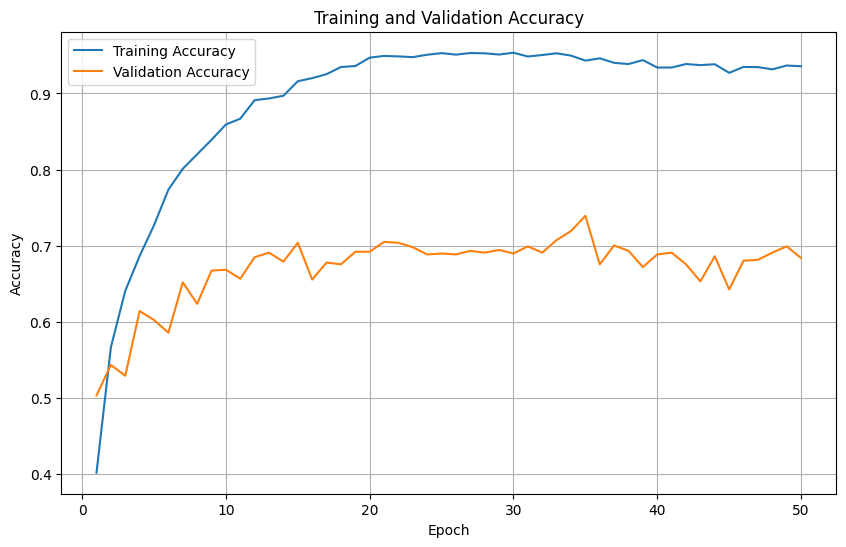

In [15]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### **Training and Validation Loss**

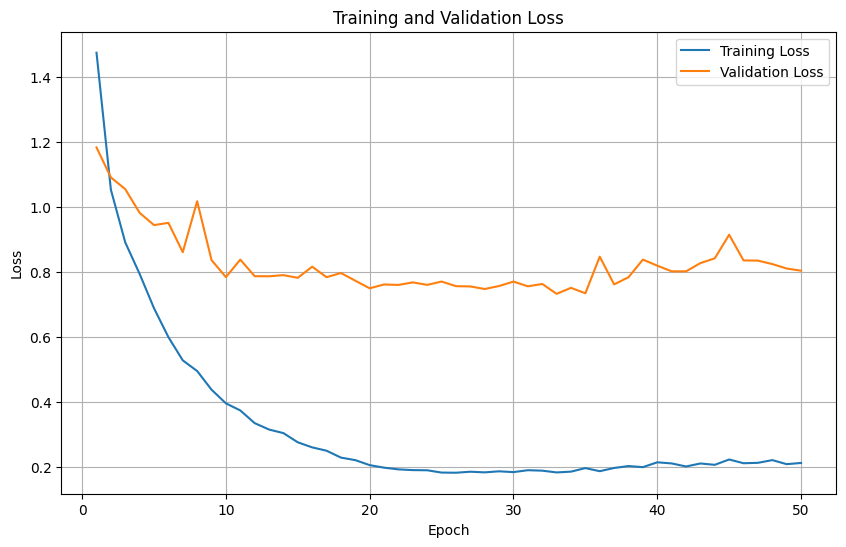

In [16]:
import matplotlib.pyplot as plt
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
utils.test_model(cnn_model, test_loader)

Test acc: 0.716


In [18]:
torch.save(cnn_model, path_to_save+'cnn')
torch.cuda.empty_cache()
cnn_model.to('cpu')

CNN(
  (conv1): Sequential(
    (0): Conv1d(22, 25, kernel_size=(5,), stride=(1,))
    (1): ReLU()
    (2): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3647999634687216, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(25, 50, kernel_size=(1, 25), stride=(1, 1))
    (1): ELU(alpha=1.0)
    (2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3647999634687216, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv1d(50, 100, kernel_size=(6,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3647999634687216, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv1d(100, 405, kernel_size=(5,), stri

# **CNN-GRU**

In [19]:
torchinfo.summary(cgru.CGRU(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CGRU                                     [64, 4]                   --
├─Sequential: 1-1                        [64, 25, 396]             --
│    └─Conv1d: 2-1                       [64, 25, 396]             2,775
│    └─ReLU: 2-2                         [64, 25, 396]             --
│    └─BatchNorm1d: 2-3                  [64, 25, 396]             50
│    └─Dropout: 2-4                      [64, 25, 396]             --
├─Sequential: 1-2                        [64, 50, 1, 124]          --
│    └─Conv2d: 2-5                       [64, 50, 1, 372]          31,300
│    └─ELU: 2-6                          [64, 50, 1, 372]          --
│    └─BatchNorm2d: 2-7                  [64, 50, 1, 372]          100
│    └─MaxPool2d: 2-8                    [64, 50, 1, 124]          --
│    └─Dropout: 2-9                      [64, 50, 1, 124]          --
├─Sequential: 1-3                        [64, 100, 39]             --
│    └─

In [20]:
cgru_model = cgru.CGRU().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(cgru_model.parameters(),
                               lr=0.001767340543208569,
                               weight_decay=0.008272087903010924)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       T_max=T_max, 
                                                       eta_min=eta_min)

### **Train the model**

In [21]:
train_accuracies, train_losses, val_accuracies, val_losses = utils.train_model(model=cgru_model,
                                                                               criterion=criterion,
                                                                               optimizer=optimizer,
                                                                               scheduler=scheduler,
                                                                               train_loader=train_loader,
                                                                               val_loader=val_loader,
                                                                               num_epochs=num_epochs,
                                                                               learning=False,
                                                                               device=device,
                                                                               trial=None)

Epoch 1


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.360, Train loss: 1.319
Val acc: 0.361, Val loss: 1.370

Epoch 2


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.484, Train loss: 1.157
Val acc: 0.474, Val loss: 1.181

Epoch 3


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.551, Train loss: 1.050
Val acc: 0.462, Val loss: 1.205

Epoch 4


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.609, Train loss: 0.955
Val acc: 0.520, Val loss: 1.130

Epoch 5


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.672, Train loss: 0.826
Val acc: 0.581, Val loss: 1.011

Epoch 6


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.726, Train loss: 0.714
Val acc: 0.629, Val loss: 0.923

Epoch 7


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.773, Train loss: 0.612
Val acc: 0.670, Val loss: 0.870

Epoch 8


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.802, Train loss: 0.536
Val acc: 0.673, Val loss: 0.889

Epoch 9


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.831, Train loss: 0.458
Val acc: 0.678, Val loss: 0.835

Epoch 10


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.852, Train loss: 0.417
Val acc: 0.649, Val loss: 0.947

Epoch 11


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.875, Train loss: 0.351
Val acc: 0.672, Val loss: 0.880

Epoch 12


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.893, Train loss: 0.317
Val acc: 0.712, Val loss: 0.818

Epoch 13


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.907, Train loss: 0.274
Val acc: 0.688, Val loss: 0.920

Epoch 14


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.924, Train loss: 0.225
Val acc: 0.703, Val loss: 0.980

Epoch 15


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.927, Train loss: 0.209
Val acc: 0.723, Val loss: 0.844

Epoch 16


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.942, Train loss: 0.180
Val acc: 0.723, Val loss: 0.839

Epoch 17


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.945, Train loss: 0.171
Val acc: 0.711, Val loss: 0.857

Epoch 18


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.950, Train loss: 0.156
Val acc: 0.731, Val loss: 0.835

Epoch 19


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.960, Train loss: 0.135
Val acc: 0.722, Val loss: 0.843

Epoch 20


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.967, Train loss: 0.120
Val acc: 0.725, Val loss: 0.891

Epoch 21


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.963, Train loss: 0.124
Val acc: 0.739, Val loss: 0.852

Epoch 22


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.969, Train loss: 0.114
Val acc: 0.732, Val loss: 0.834

Epoch 23


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.971, Train loss: 0.109
Val acc: 0.736, Val loss: 0.839

Epoch 24


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.972, Train loss: 0.100
Val acc: 0.748, Val loss: 0.843

Epoch 25


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.973, Train loss: 0.100
Val acc: 0.742, Val loss: 0.860

Epoch 26


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.974, Train loss: 0.102
Val acc: 0.738, Val loss: 0.832

Epoch 27


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.973, Train loss: 0.099
Val acc: 0.742, Val loss: 0.843

Epoch 28


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.974, Train loss: 0.098
Val acc: 0.742, Val loss: 0.851

Epoch 29


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.972, Train loss: 0.105
Val acc: 0.737, Val loss: 0.852

Epoch 30


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.970, Train loss: 0.105
Val acc: 0.737, Val loss: 0.837

Epoch 31


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.972, Train loss: 0.103
Val acc: 0.737, Val loss: 0.846

Epoch 32


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.974, Train loss: 0.098
Val acc: 0.743, Val loss: 0.841

Epoch 33


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.971, Train loss: 0.102
Val acc: 0.744, Val loss: 0.868

Epoch 34


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.965, Train loss: 0.117
Val acc: 0.731, Val loss: 0.832

Epoch 35


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.964, Train loss: 0.118
Val acc: 0.704, Val loss: 0.826

Epoch 36


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.959, Train loss: 0.133
Val acc: 0.737, Val loss: 0.809

Epoch 37


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.955, Train loss: 0.136
Val acc: 0.719, Val loss: 0.828

Epoch 38


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.955, Train loss: 0.147
Val acc: 0.732, Val loss: 0.844

Epoch 39


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.951, Train loss: 0.151
Val acc: 0.724, Val loss: 0.967

Epoch 40


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.945, Train loss: 0.164
Val acc: 0.723, Val loss: 0.915

Epoch 41


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.943, Train loss: 0.172
Val acc: 0.692, Val loss: 0.963

Epoch 42


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.938, Train loss: 0.184
Val acc: 0.686, Val loss: 0.907

Epoch 43


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.927, Train loss: 0.210
Val acc: 0.685, Val loss: 0.937

Epoch 44


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.937, Train loss: 0.191
Val acc: 0.693, Val loss: 0.898

Epoch 45


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.927, Train loss: 0.209
Val acc: 0.697, Val loss: 0.864

Epoch 46


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.938, Train loss: 0.181
Val acc: 0.682, Val loss: 0.960

Epoch 47


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.931, Train loss: 0.213
Val acc: 0.660, Val loss: 1.006

Epoch 48


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.939, Train loss: 0.183
Val acc: 0.692, Val loss: 0.941

Epoch 49


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.939, Train loss: 0.184
Val acc: 0.696, Val loss: 0.833

Epoch 50


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.948, Train loss: 0.168
Val acc: 0.732, Val loss: 0.817



### **Training and Validation Accuracy Graph**

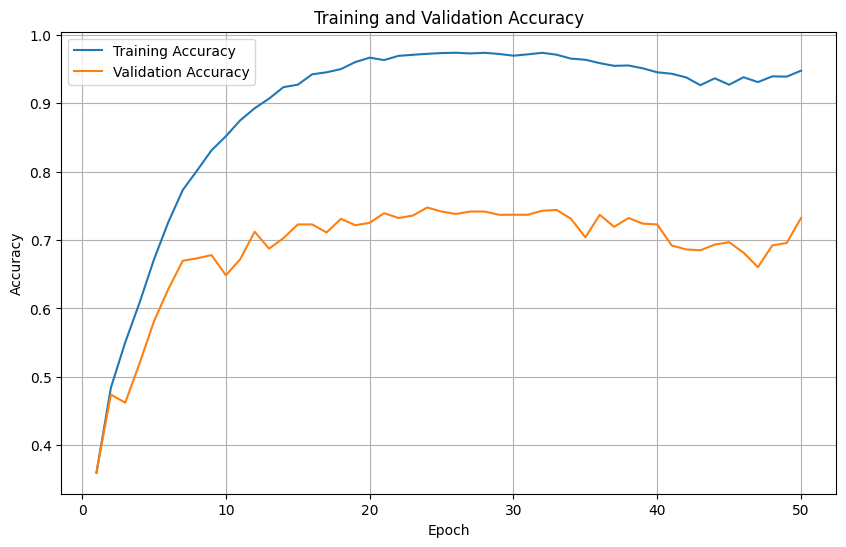

In [22]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### **Training and Validation Loss**

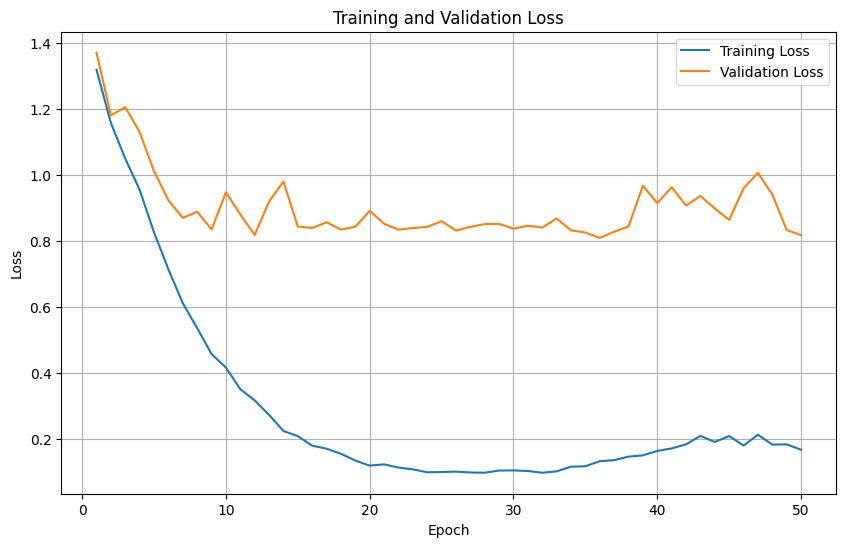

In [23]:
import matplotlib.pyplot as plt
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
utils.test_model(cgru_model, test_loader)

Test acc: 0.659


In [25]:
torch.save(cgru_model, path_to_save+'cgru')
torch.cuda.empty_cache()
cgru_model.to('cpu')

CGRU(
  (conv1): Sequential(
    (0): Conv1d(22, 25, kernel_size=(5,), stride=(1,))
    (1): ReLU()
    (2): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3647999634687216, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(25, 50, kernel_size=(1, 25), stride=(1, 1))
    (1): ELU(alpha=1.0)
    (2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3647999634687216, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv1d(50, 100, kernel_size=(6,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3647999634687216, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv1d(100, 405, kernel_size=(5,), str

# **CNN-LSTM**

In [26]:
torchinfo.summary(clstm.CLSTM(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CLSTM                                    [64, 4]                   --
├─Sequential: 1-1                        [64, 25, 396]             --
│    └─Conv1d: 2-1                       [64, 25, 396]             2,775
│    └─ReLU: 2-2                         [64, 25, 396]             --
│    └─BatchNorm1d: 2-3                  [64, 25, 396]             50
│    └─Dropout: 2-4                      [64, 25, 396]             --
├─Sequential: 1-2                        [64, 50, 1, 124]          --
│    └─Conv2d: 2-5                       [64, 50, 1, 372]          31,300
│    └─ELU: 2-6                          [64, 50, 1, 372]          --
│    └─BatchNorm2d: 2-7                  [64, 50, 1, 372]          100
│    └─MaxPool2d: 2-8                    [64, 50, 1, 124]          --
│    └─Dropout: 2-9                      [64, 50, 1, 124]          --
├─Sequential: 1-3                        [64, 100, 39]             --
│    └─

In [27]:
clstm_model = clstm.CLSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(clstm_model.parameters(),
                               lr=0.001767340543208569,
                               weight_decay=0.008272087903010924)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       T_max=T_max, 
                                                       eta_min=eta_min)

### **Train the model**

In [28]:
train_accuracies, train_losses, val_accuracies, val_losses = utils.train_model(model=clstm_model,
                                                                               criterion=criterion,
                                                                               optimizer=optimizer,
                                                                               scheduler=scheduler,
                                                                               train_loader=train_loader,
                                                                               val_loader=val_loader,
                                                                               num_epochs=num_epochs,
                                                                               learning=False,
                                                                               device=device,
                                                                               trial=None)

Epoch 1


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.357, Train loss: 1.327
Val acc: 0.380, Val loss: 1.350

Epoch 2


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.465, Train loss: 1.188
Val acc: 0.421, Val loss: 1.239

Epoch 3


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.508, Train loss: 1.105
Val acc: 0.448, Val loss: 1.187

Epoch 4


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.546, Train loss: 1.027
Val acc: 0.427, Val loss: 1.208

Epoch 5


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.571, Train loss: 0.970
Val acc: 0.441, Val loss: 1.167

Epoch 6


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.596, Train loss: 0.906
Val acc: 0.502, Val loss: 1.131

Epoch 7


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.619, Train loss: 0.854
Val acc: 0.553, Val loss: 1.063

Epoch 8


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.642, Train loss: 0.802
Val acc: 0.539, Val loss: 1.010

Epoch 9


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.672, Train loss: 0.748
Val acc: 0.566, Val loss: 1.018

Epoch 10


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.686, Train loss: 0.703
Val acc: 0.528, Val loss: 1.030

Epoch 11


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.707, Train loss: 0.659
Val acc: 0.567, Val loss: 1.018

Epoch 12


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.719, Train loss: 0.635
Val acc: 0.580, Val loss: 0.981

Epoch 13


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.751, Train loss: 0.577
Val acc: 0.606, Val loss: 0.997

Epoch 14


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.780, Train loss: 0.546
Val acc: 0.632, Val loss: 0.964

Epoch 15


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.802, Train loss: 0.503
Val acc: 0.642, Val loss: 0.920

Epoch 16


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.837, Train loss: 0.463
Val acc: 0.619, Val loss: 0.993

Epoch 17


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.852, Train loss: 0.437
Val acc: 0.640, Val loss: 0.945

Epoch 18


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.883, Train loss: 0.377
Val acc: 0.658, Val loss: 0.942

Epoch 19


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.898, Train loss: 0.345
Val acc: 0.677, Val loss: 0.896

Epoch 20


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.909, Train loss: 0.324
Val acc: 0.685, Val loss: 0.930

Epoch 21


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.919, Train loss: 0.302
Val acc: 0.667, Val loss: 0.912

Epoch 22


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.922, Train loss: 0.291
Val acc: 0.670, Val loss: 0.918

Epoch 23


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.929, Train loss: 0.277
Val acc: 0.690, Val loss: 0.885

Epoch 24


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.930, Train loss: 0.275
Val acc: 0.684, Val loss: 0.902

Epoch 25


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.938, Train loss: 0.260
Val acc: 0.672, Val loss: 0.900

Epoch 26


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.932, Train loss: 0.264
Val acc: 0.682, Val loss: 0.899

Epoch 27


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.936, Train loss: 0.262
Val acc: 0.676, Val loss: 0.899

Epoch 28


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.937, Train loss: 0.259
Val acc: 0.671, Val loss: 0.918

Epoch 29


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.931, Train loss: 0.261
Val acc: 0.683, Val loss: 0.920

Epoch 30


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.932, Train loss: 0.258
Val acc: 0.693, Val loss: 0.877

Epoch 31


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.939, Train loss: 0.251
Val acc: 0.699, Val loss: 0.882

Epoch 32


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.930, Train loss: 0.260
Val acc: 0.684, Val loss: 0.902

Epoch 33


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.933, Train loss: 0.253
Val acc: 0.682, Val loss: 0.907

Epoch 34


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.935, Train loss: 0.250
Val acc: 0.690, Val loss: 0.893

Epoch 35


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.927, Train loss: 0.276
Val acc: 0.649, Val loss: 0.982

Epoch 36


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.931, Train loss: 0.262
Val acc: 0.680, Val loss: 0.891

Epoch 37


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.935, Train loss: 0.256
Val acc: 0.656, Val loss: 0.968

Epoch 38


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.924, Train loss: 0.274
Val acc: 0.656, Val loss: 0.933

Epoch 39


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.919, Train loss: 0.278
Val acc: 0.675, Val loss: 0.906

Epoch 40


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.917, Train loss: 0.289
Val acc: 0.695, Val loss: 0.871

Epoch 41


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.916, Train loss: 0.295
Val acc: 0.683, Val loss: 0.832

Epoch 42


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.918, Train loss: 0.286
Val acc: 0.669, Val loss: 0.934

Epoch 43


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.910, Train loss: 0.300
Val acc: 0.671, Val loss: 0.931

Epoch 44


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.913, Train loss: 0.296
Val acc: 0.630, Val loss: 0.979

Epoch 45


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.915, Train loss: 0.290
Val acc: 0.658, Val loss: 0.918

Epoch 46


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.911, Train loss: 0.299
Val acc: 0.621, Val loss: 1.091

Epoch 47


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.919, Train loss: 0.284
Val acc: 0.612, Val loss: 1.034

Epoch 48


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.909, Train loss: 0.292
Val acc: 0.643, Val loss: 1.010

Epoch 49


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.909, Train loss: 0.285
Val acc: 0.626, Val loss: 0.973

Epoch 50


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.914, Train loss: 0.273
Val acc: 0.565, Val loss: 1.139



### **Training and Validation Accuracy Graph**

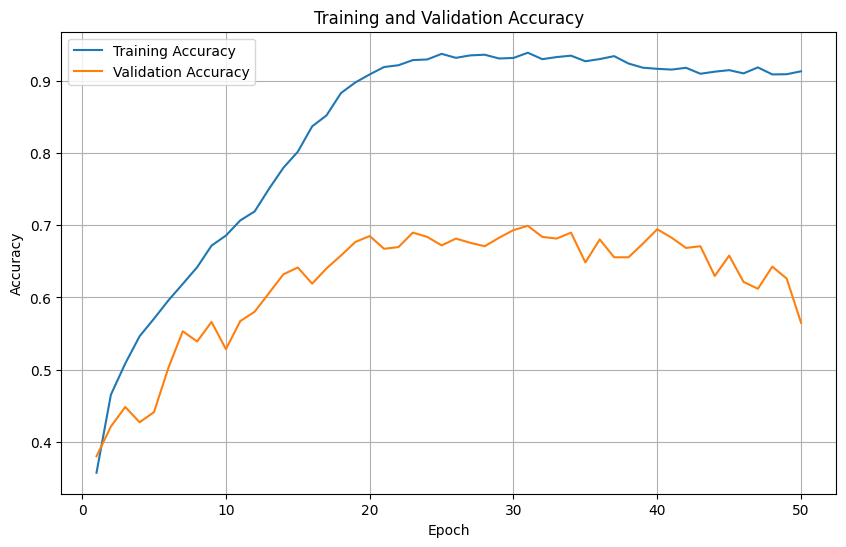

In [29]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### **Training and Validation Loss**

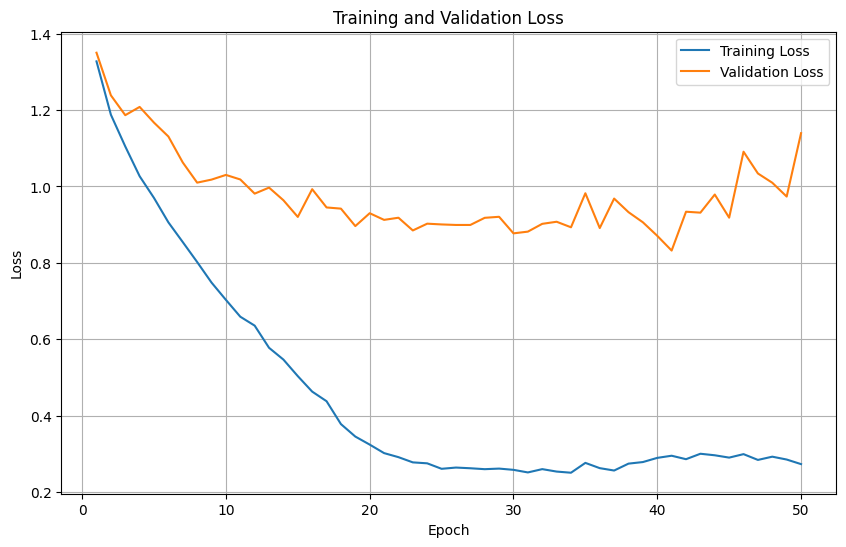

In [30]:
import matplotlib.pyplot as plt
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
utils.test_model(clstm_model, test_loader)

Test acc: 0.619


In [32]:
torch.save(clstm_model, path_to_save+'clstm')
torch.cuda.empty_cache()

# **CNN-Transformer**

In [33]:
torchinfo.summary(ctransformer.CTransformer(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                        Output Shape              Param #
CTransformer                                  [64, 4]                   --
├─Sequential: 1-1                             [64, 25, 396]             --
│    └─Conv1d: 2-1                            [64, 25, 396]             2,775
│    └─ReLU: 2-2                              [64, 25, 396]             --
│    └─BatchNorm1d: 2-3                       [64, 25, 396]             50
│    └─Dropout: 2-4                           [64, 25, 396]             --
├─Sequential: 1-2                             [64, 200, 1, 124]         --
│    └─Conv2d: 2-5                            [64, 200, 1, 372]         125,200
│    └─ELU: 2-6                               [64, 200, 1, 372]         --
│    └─BatchNorm2d: 2-7                       [64, 200, 1, 372]         400
│    └─MaxPool2d: 2-8                         [64, 200, 1, 124]         --
│    └─Dropout: 2-9                           [64, 200, 1, 124]         --
├─Positiona

In [34]:
ctransformer_model = ctransformer.CTransformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(ctransformer_model.parameters(),
                              lr=0.001767340543208569,
                              betas=(0.9,0.999),
                              weight_decay=0.008272087903010924,
                              eps=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       T_max=T_max, 
                                                       eta_min=eta_min)

### **Train the model**

In [35]:
train_accuracies, train_losses, val_accuracies, val_losses = utils.train_model(model=ctransformer_model,
                                                                               criterion=criterion,
                                                                               optimizer=optimizer,
                                                                               scheduler=scheduler,
                                                                               train_loader=train_loader,
                                                                               val_loader=val_loader,
                                                                               num_epochs=num_epochs,
                                                                               learning=False,
                                                                               device=device,
                                                                               trial=None)

Epoch 1


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.267, Train loss: 1.436
Val acc: 0.248, Val loss: 1.414

Epoch 2


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.329, Train loss: 1.352
Val acc: 0.279, Val loss: 1.452

Epoch 3


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.403, Train loss: 1.271
Val acc: 0.389, Val loss: 1.307

Epoch 4


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.484, Train loss: 1.163
Val acc: 0.469, Val loss: 1.270

Epoch 5


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.541, Train loss: 1.078
Val acc: 0.486, Val loss: 1.218

Epoch 6


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.598, Train loss: 0.982
Val acc: 0.553, Val loss: 1.186

Epoch 7


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.629, Train loss: 0.911
Val acc: 0.514, Val loss: 1.331

Epoch 8


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.663, Train loss: 0.841
Val acc: 0.518, Val loss: 1.317

Epoch 9


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.689, Train loss: 0.782
Val acc: 0.562, Val loss: 1.243

Epoch 10


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.720, Train loss: 0.708
Val acc: 0.606, Val loss: 1.122

Epoch 11


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.742, Train loss: 0.655
Val acc: 0.620, Val loss: 1.178

Epoch 12


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.773, Train loss: 0.592
Val acc: 0.634, Val loss: 1.178

Epoch 13


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.795, Train loss: 0.537
Val acc: 0.583, Val loss: 1.220

Epoch 14


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.820, Train loss: 0.476
Val acc: 0.618, Val loss: 1.286

Epoch 15


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.833, Train loss: 0.445
Val acc: 0.631, Val loss: 1.338

Epoch 16


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.854, Train loss: 0.386
Val acc: 0.670, Val loss: 1.227

Epoch 17


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.869, Train loss: 0.345
Val acc: 0.633, Val loss: 1.263

Epoch 18


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.890, Train loss: 0.305
Val acc: 0.632, Val loss: 1.485

Epoch 19


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.904, Train loss: 0.257
Val acc: 0.653, Val loss: 1.397

Epoch 20


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.910, Train loss: 0.236
Val acc: 0.660, Val loss: 1.341

Epoch 21


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.921, Train loss: 0.212
Val acc: 0.664, Val loss: 1.421

Epoch 22


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.929, Train loss: 0.192
Val acc: 0.670, Val loss: 1.400

Epoch 23


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.936, Train loss: 0.182
Val acc: 0.673, Val loss: 1.412

Epoch 24


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.936, Train loss: 0.178
Val acc: 0.670, Val loss: 1.426

Epoch 25


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.946, Train loss: 0.155
Val acc: 0.666, Val loss: 1.442

Epoch 26


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.942, Train loss: 0.155
Val acc: 0.664, Val loss: 1.456

Epoch 27


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.940, Train loss: 0.159
Val acc: 0.673, Val loss: 1.456

Epoch 28


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.938, Train loss: 0.172
Val acc: 0.660, Val loss: 1.468

Epoch 29


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.943, Train loss: 0.157
Val acc: 0.670, Val loss: 1.479

Epoch 30


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.939, Train loss: 0.164
Val acc: 0.640, Val loss: 1.561

Epoch 31


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.934, Train loss: 0.171
Val acc: 0.663, Val loss: 1.549

Epoch 32


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.938, Train loss: 0.168
Val acc: 0.670, Val loss: 1.507

Epoch 33


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.933, Train loss: 0.179
Val acc: 0.689, Val loss: 1.527

Epoch 34


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.935, Train loss: 0.175
Val acc: 0.685, Val loss: 1.517

Epoch 35


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.930, Train loss: 0.198
Val acc: 0.665, Val loss: 1.497

Epoch 36


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.922, Train loss: 0.213
Val acc: 0.673, Val loss: 1.503

Epoch 37


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.919, Train loss: 0.220
Val acc: 0.664, Val loss: 1.548

Epoch 38


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.912, Train loss: 0.238
Val acc: 0.646, Val loss: 1.472

Epoch 39


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.906, Train loss: 0.253
Val acc: 0.676, Val loss: 1.514

Epoch 40


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.898, Train loss: 0.278
Val acc: 0.636, Val loss: 1.515

Epoch 41


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.887, Train loss: 0.298
Val acc: 0.683, Val loss: 1.335

Epoch 42


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.885, Train loss: 0.301
Val acc: 0.644, Val loss: 1.310

Epoch 43


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.882, Train loss: 0.306
Val acc: 0.662, Val loss: 1.476

Epoch 44


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.888, Train loss: 0.301
Val acc: 0.651, Val loss: 1.416

Epoch 45


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.875, Train loss: 0.334
Val acc: 0.637, Val loss: 1.544

Epoch 46


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.875, Train loss: 0.343
Val acc: 0.638, Val loss: 1.409

Epoch 47


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.877, Train loss: 0.326
Val acc: 0.663, Val loss: 1.433

Epoch 48


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.881, Train loss: 0.319
Val acc: 0.620, Val loss: 1.453

Epoch 49


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.875, Train loss: 0.335
Val acc: 0.680, Val loss: 1.295

Epoch 50


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.869, Train loss: 0.343
Val acc: 0.642, Val loss: 1.482



### **Training and Validation Accuracy Graph**

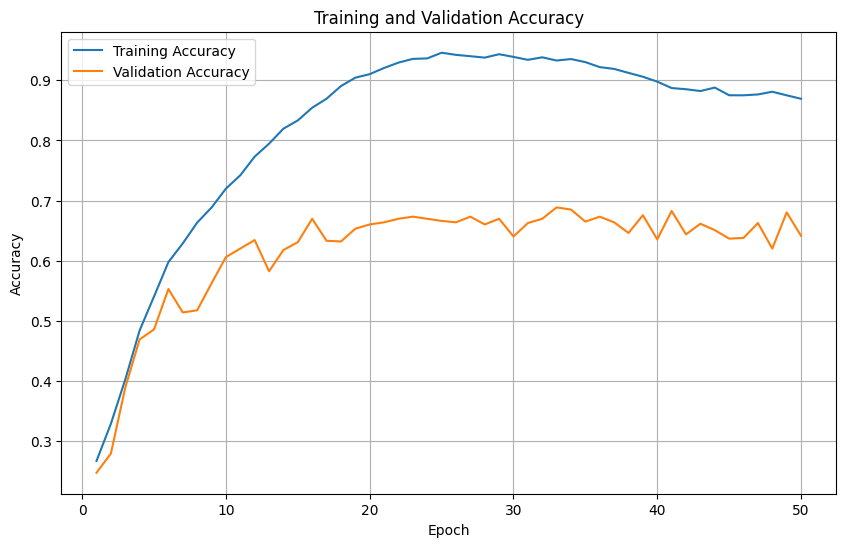

In [36]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### **Training and Validation Loss**

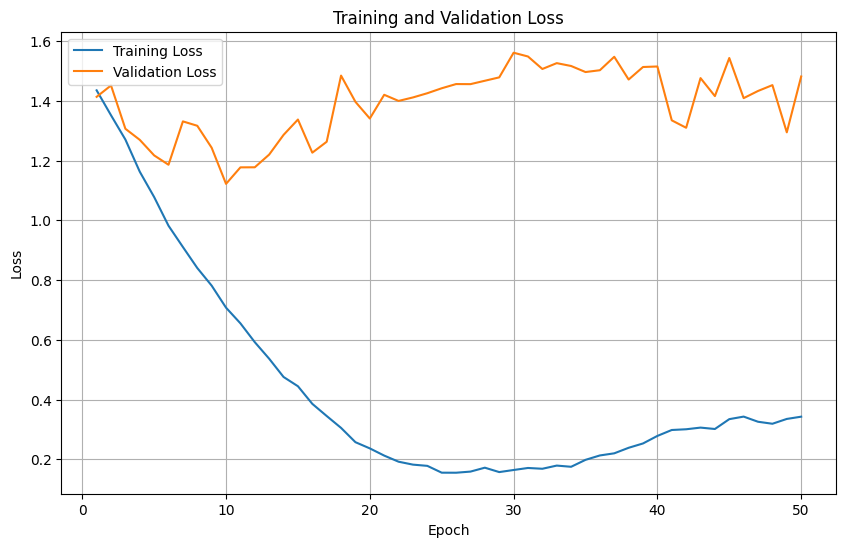

In [37]:
import matplotlib.pyplot as plt
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
utils.test_model(ctransformer_model, test_loader)

Test acc: 0.639


In [39]:
torch.save(ctransformer_model, path_to_save+'ctransformer')
torch.cuda.empty_cache()

# **GRU**

In [40]:
torchinfo.summary(gru.GRU(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      [64, 54]                  2,688
├─GRU: 1-1                               [64, 400, 128]            182,784
├─Linear: 1-2                            [64, 54]                  6,966
Total params: 192,438
Trainable params: 192,438
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 4.68
Input size (MB): 2.25
Forward/backward pass size (MB): 26.24
Params size (MB): 0.76
Estimated Total Size (MB): 29.25

In [41]:
gru_model = gru.GRU().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(gru_model.parameters(),
                             lr=0.001767340543208569,
                             weight_decay=0.008272087903010924)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       T_max=T_max, 
                                                       eta_min=eta_min)

### **Train the model**

In [42]:
train_accuracies, train_losses, val_accuracies, val_losses = utils.train_model(model=gru_model,
                                                                               criterion=criterion,
                                                                               optimizer=optimizer,
                                                                               scheduler=scheduler,
                                                                               train_loader=train_loader,
                                                                               val_loader=val_loader,
                                                                               num_epochs=num_epochs,
                                                                               learning=False,
                                                                               device=device,
                                                                               trial=None)

Epoch 1


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.249, Train loss: 1.522
Val acc: 0.269, Val loss: 1.394

Epoch 2


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.258, Train loss: 1.396
Val acc: 0.244, Val loss: 1.391

Epoch 3


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.244, Train loss: 1.396
Val acc: 0.243, Val loss: 1.389

Epoch 4


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.256, Train loss: 1.396
Val acc: 0.268, Val loss: 1.403

Epoch 5


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.246, Train loss: 1.395
Val acc: 0.217, Val loss: 1.392

Epoch 6


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.253, Train loss: 1.394
Val acc: 0.261, Val loss: 1.395

Epoch 7


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.255, Train loss: 1.394
Val acc: 0.217, Val loss: 1.397

Epoch 8


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.255, Train loss: 1.396
Val acc: 0.212, Val loss: 1.395

Epoch 9


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.251, Train loss: 1.391
Val acc: 0.211, Val loss: 1.403

Epoch 10


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.258, Train loss: 1.391
Val acc: 0.264, Val loss: 1.394

Epoch 11


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.260, Train loss: 1.389
Val acc: 0.231, Val loss: 1.407

Epoch 12


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.270, Train loss: 1.390
Val acc: 0.265, Val loss: 1.400

Epoch 13


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.279, Train loss: 1.384
Val acc: 0.223, Val loss: 1.425

Epoch 14


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.274, Train loss: 1.384
Val acc: 0.224, Val loss: 1.403

Epoch 15


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.279, Train loss: 1.380
Val acc: 0.229, Val loss: 1.406

Epoch 16


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.290, Train loss: 1.378
Val acc: 0.222, Val loss: 1.414

Epoch 17


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.288, Train loss: 1.372
Val acc: 0.213, Val loss: 1.411

Epoch 18


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.307, Train loss: 1.370
Val acc: 0.223, Val loss: 1.427

Epoch 19


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.296, Train loss: 1.369
Val acc: 0.212, Val loss: 1.417

Epoch 20


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.302, Train loss: 1.365
Val acc: 0.212, Val loss: 1.411

Epoch 21


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.305, Train loss: 1.360
Val acc: 0.212, Val loss: 1.417

Epoch 22


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.316, Train loss: 1.361
Val acc: 0.217, Val loss: 1.420

Epoch 23


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.319, Train loss: 1.357
Val acc: 0.208, Val loss: 1.419

Epoch 24


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.321, Train loss: 1.356
Val acc: 0.202, Val loss: 1.423

Epoch 25


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.319, Train loss: 1.357
Val acc: 0.205, Val loss: 1.422

Epoch 26


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.317, Train loss: 1.355
Val acc: 0.206, Val loss: 1.423

Epoch 27


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.314, Train loss: 1.355
Val acc: 0.205, Val loss: 1.423

Epoch 28


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.319, Train loss: 1.357
Val acc: 0.210, Val loss: 1.423

Epoch 29


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.317, Train loss: 1.357
Val acc: 0.213, Val loss: 1.425

Epoch 30


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.318, Train loss: 1.356
Val acc: 0.219, Val loss: 1.431

Epoch 31


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.315, Train loss: 1.359
Val acc: 0.211, Val loss: 1.425

Epoch 32


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.318, Train loss: 1.360
Val acc: 0.210, Val loss: 1.429

Epoch 33


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.319, Train loss: 1.354
Val acc: 0.239, Val loss: 1.429

Epoch 34


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.317, Train loss: 1.355
Val acc: 0.224, Val loss: 1.423

Epoch 35


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.320, Train loss: 1.353
Val acc: 0.238, Val loss: 1.433

Epoch 36


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.311, Train loss: 1.358
Val acc: 0.213, Val loss: 1.433

Epoch 37


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.310, Train loss: 1.355
Val acc: 0.215, Val loss: 1.435

Epoch 38


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.317, Train loss: 1.358
Val acc: 0.235, Val loss: 1.422

Epoch 39


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.318, Train loss: 1.357
Val acc: 0.245, Val loss: 1.428

Epoch 40


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.323, Train loss: 1.355
Val acc: 0.215, Val loss: 1.425

Epoch 41


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.319, Train loss: 1.355
Val acc: 0.241, Val loss: 1.433

Epoch 42


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.319, Train loss: 1.355
Val acc: 0.246, Val loss: 1.432

Epoch 43


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.318, Train loss: 1.355
Val acc: 0.261, Val loss: 1.425

Epoch 44


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.315, Train loss: 1.359
Val acc: 0.206, Val loss: 1.444

Epoch 45


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.326, Train loss: 1.351
Val acc: 0.231, Val loss: 1.438

Epoch 46


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.311, Train loss: 1.362
Val acc: 0.248, Val loss: 1.447

Epoch 47


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.314, Train loss: 1.355
Val acc: 0.219, Val loss: 1.433

Epoch 48


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.335, Train loss: 1.347
Val acc: 0.279, Val loss: 1.420

Epoch 49


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.316, Train loss: 1.355
Val acc: 0.216, Val loss: 1.476

Epoch 50


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.323, Train loss: 1.353
Val acc: 0.229, Val loss: 1.457



### **Training and Validation Accuracy Graph**

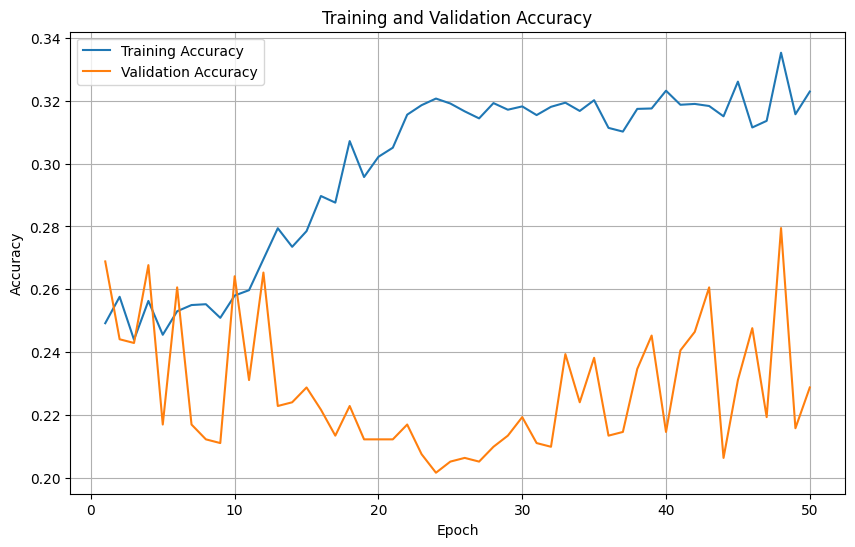

In [43]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### **Training and Validation Loss**

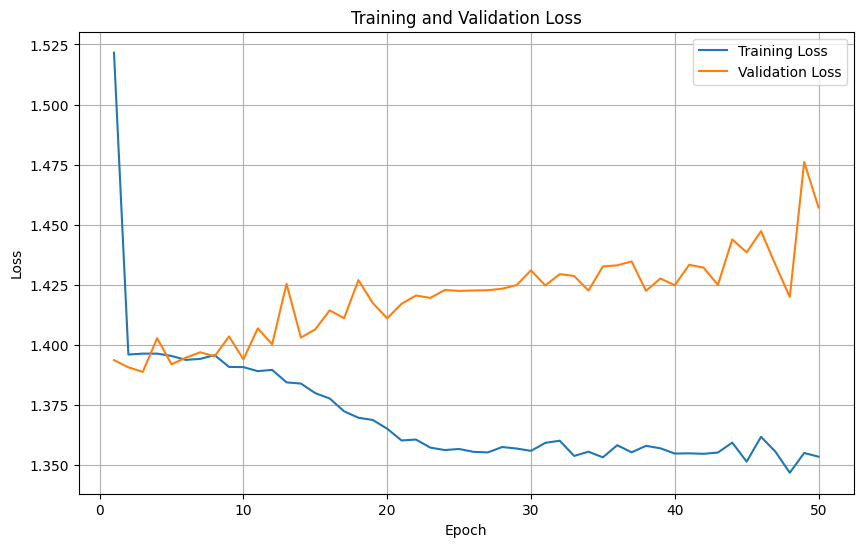

In [44]:
import matplotlib.pyplot as plt
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
utils.test_model(gru_model, test_loader)

Test acc: 0.269


In [46]:
torch.save(gru_model, path_to_save+'gru')
torch.cuda.empty_cache()
gru_model.to('cpu')

GRU(
  (gru): GRU(22, 64, num_layers=3, dropout=0.5, bidirectional=True)
  (linear): Linear(in_features=128, out_features=54, bias=True)
  (fc): Sequential(
    (0): Linear(in_features=54, out_features=44, bias=True)
    (1): BatchNorm1d(44, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=44, out_features=4, bias=True)
  )
)

# **LSTM-LSTM**

In [47]:
torchinfo.summary(llstm.LSTM_LSTM(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM_LSTM                                [64, 54]                  2,688
├─LSTM: 1-1                              [64, 400, 128]            144,384
├─LSTM: 1-2                              [64, 400, 128]            198,656
├─Linear: 1-3                            [64, 54]                  6,966
Total params: 352,694
Trainable params: 352,694
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 8.78
Input size (MB): 2.25
Forward/backward pass size (MB): 52.46
Params size (MB): 1.40
Estimated Total Size (MB): 56.11

In [48]:
llstm_model = llstm.LSTM_LSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(llstm_model.parameters(),
                             lr=0.001767340543208569,
                             weight_decay=0.008272087903010924)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       T_max=T_max, 
                                                       eta_min=eta_min)

### **Train the model**

In [49]:
train_accuracies, train_losses, val_accuracies, val_losses = utils.train_model(model=llstm_model,
                                                                               criterion=criterion,
                                                                               optimizer=optimizer,
                                                                               scheduler=scheduler,
                                                                               train_loader=train_loader,
                                                                               val_loader=val_loader,
                                                                               num_epochs=num_epochs,
                                                                               learning=False,
                                                                               device=device,
                                                                               trial=None)

Epoch 1


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.242, Train loss: 1.595
Val acc: 0.269, Val loss: 1.392

Epoch 2


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.259, Train loss: 1.394
Val acc: 0.250, Val loss: 1.403

Epoch 3


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.246, Train loss: 1.398
Val acc: 0.250, Val loss: 1.391

Epoch 4


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.246, Train loss: 1.394
Val acc: 0.217, Val loss: 1.414

Epoch 5


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.255, Train loss: 1.392
Val acc: 0.269, Val loss: 1.396

Epoch 6


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.262, Train loss: 1.393
Val acc: 0.217, Val loss: 1.394

Epoch 7


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.246, Train loss: 1.392
Val acc: 0.269, Val loss: 1.384

Epoch 8


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.245, Train loss: 1.395
Val acc: 0.264, Val loss: 1.388

Epoch 9


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.248, Train loss: 1.393
Val acc: 0.269, Val loss: 1.387

Epoch 10


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.270, Train loss: 1.387
Val acc: 0.215, Val loss: 1.404

Epoch 11


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.305, Train loss: 1.369
Val acc: 0.230, Val loss: 1.404

Epoch 12


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.333, Train loss: 1.339
Val acc: 0.238, Val loss: 1.412

Epoch 13


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.359, Train loss: 1.301
Val acc: 0.252, Val loss: 1.430

Epoch 14


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.399, Train loss: 1.254
Val acc: 0.242, Val loss: 1.516

Epoch 15


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.441, Train loss: 1.200
Val acc: 0.230, Val loss: 1.564

Epoch 16


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.485, Train loss: 1.134
Val acc: 0.241, Val loss: 1.561

Epoch 17


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.531, Train loss: 1.068
Val acc: 0.251, Val loss: 1.634

Epoch 18


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.577, Train loss: 0.999
Val acc: 0.244, Val loss: 1.695

Epoch 19


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.620, Train loss: 0.930
Val acc: 0.228, Val loss: 1.835

Epoch 20


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.657, Train loss: 0.870
Val acc: 0.236, Val loss: 1.873

Epoch 21


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.688, Train loss: 0.817
Val acc: 0.243, Val loss: 1.949

Epoch 22


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.714, Train loss: 0.773
Val acc: 0.250, Val loss: 1.977

Epoch 23


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.733, Train loss: 0.740
Val acc: 0.245, Val loss: 2.026

Epoch 24


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.742, Train loss: 0.721
Val acc: 0.246, Val loss: 2.036

Epoch 25


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.752, Train loss: 0.709
Val acc: 0.248, Val loss: 2.048

Epoch 26


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.753, Train loss: 0.705
Val acc: 0.249, Val loss: 2.054

Epoch 27


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.756, Train loss: 0.703
Val acc: 0.251, Val loss: 2.059

Epoch 28


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.754, Train loss: 0.702
Val acc: 0.252, Val loss: 2.079

Epoch 29


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.757, Train loss: 0.698
Val acc: 0.254, Val loss: 2.097

Epoch 30


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.758, Train loss: 0.689
Val acc: 0.254, Val loss: 2.132

Epoch 31


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.760, Train loss: 0.680
Val acc: 0.239, Val loss: 2.163

Epoch 32


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.763, Train loss: 0.673
Val acc: 0.257, Val loss: 2.162

Epoch 33


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.762, Train loss: 0.661
Val acc: 0.245, Val loss: 2.231

Epoch 34


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.758, Train loss: 0.656
Val acc: 0.237, Val loss: 2.240

Epoch 35


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.773, Train loss: 0.636
Val acc: 0.238, Val loss: 2.323

Epoch 36


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.773, Train loss: 0.629
Val acc: 0.252, Val loss: 2.245

Epoch 37


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.781, Train loss: 0.604
Val acc: 0.257, Val loss: 2.370

Epoch 38


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.781, Train loss: 0.597
Val acc: 0.238, Val loss: 2.283

Epoch 39


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.783, Train loss: 0.588
Val acc: 0.241, Val loss: 2.205

Epoch 40


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.812, Train loss: 0.529
Val acc: 0.262, Val loss: 2.536

Epoch 41


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.811, Train loss: 0.531
Val acc: 0.252, Val loss: 2.383

Epoch 42


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.824, Train loss: 0.501
Val acc: 0.256, Val loss: 2.521

Epoch 43


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.843, Train loss: 0.448
Val acc: 0.249, Val loss: 2.612

Epoch 44


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.846, Train loss: 0.435
Val acc: 0.264, Val loss: 2.498

Epoch 45


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.849, Train loss: 0.426
Val acc: 0.256, Val loss: 2.723

Epoch 46


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.874, Train loss: 0.360
Val acc: 0.261, Val loss: 2.818

Epoch 47


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.885, Train loss: 0.326
Val acc: 0.249, Val loss: 2.825

Epoch 48


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.883, Train loss: 0.333
Val acc: 0.270, Val loss: 2.911

Epoch 49


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.900, Train loss: 0.284
Val acc: 0.275, Val loss: 3.130

Epoch 50


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.922, Train loss: 0.221
Val acc: 0.243, Val loss: 3.207



### **Training and Validation Accuracy Graph**

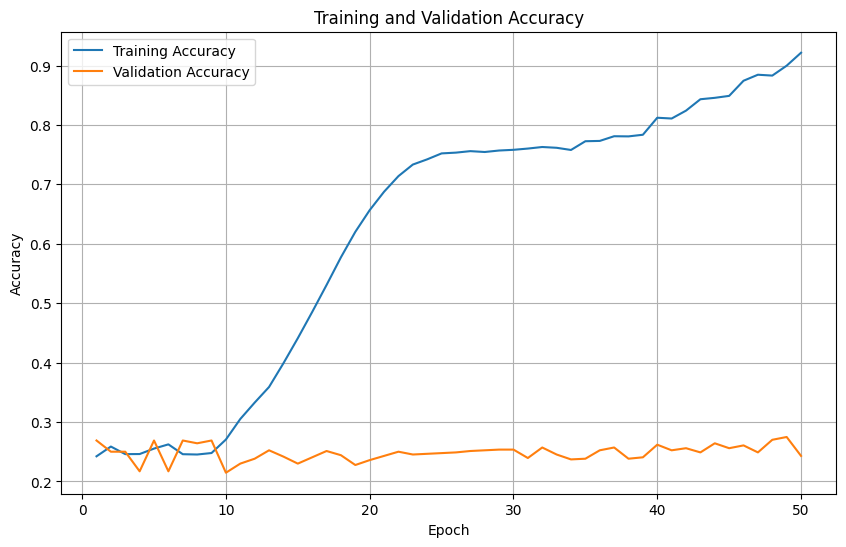

In [50]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### **Training and Validation Loss**

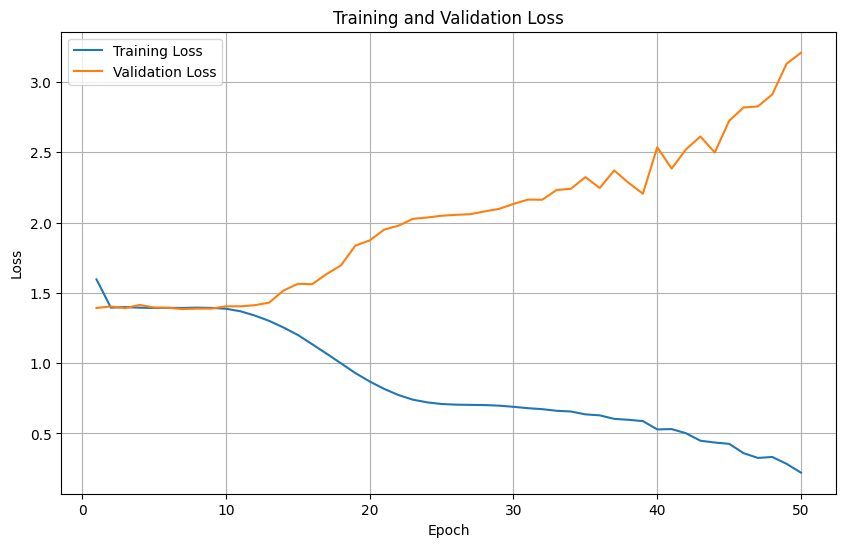

In [51]:
import matplotlib.pyplot as plt
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
utils.test_model(llstm_model, test_loader)

Test acc: 0.246


In [53]:
torch.save(llstm_model, path_to_save+'llstm')
torch.cuda.empty_cache()
llstm_model.to('cpu')

LSTM_LSTM(
  (lstm1): LSTM(22, 64, num_layers=2, batch_first=True, bidirectional=True)
  (lstm2): LSTM(128, 64, num_layers=2, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=128, out_features=54, bias=True)
  (fc): Sequential(
    (0): Linear(in_features=54, out_features=44, bias=True)
    (1): BatchNorm1d(44, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=44, out_features=4, bias=True)
  )
)

# **end**

In [57]:
end_time = time.time()
print('time i will never get back:')
hours = (end_time - start_time) // 3600
minutes = ((end_time - start_time) % 3600) // 60
seconds = (end_time - start_time) % 60

print(f'time to train models: \
{hours} hours, \
{minutes} minutes, \
{int(seconds)} seconds')

time i will never get back:
time to train models: 0.0 hours, 28.0 minutes, 0 seconds


In [ ]:
del cnn_model
del cgru_model
del clstm_model
del ctransformer_model
del gru_model
del llstm_model
gc.collect()